# Create test and validation set

In [1]:
%matplotlib inline
import os, sys
#import modules
from utils import *
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import backend as K

import os, json

from keras.layers import Input
from keras.optimizers import SGD, RMSprop, Adam
from enum import Enum
from keras.layers.core import Dense


DATA_HOME_DIR = '/srv/data/dogscats'
DATA_HOME_DIR = '/home/ubuntu/blocks_classifier/data/dogscats' # on ec2

reload(K)
K.image_dim_ordering()

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.
Using Theano backend.


'th'

# Prep data

In [10]:
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/srv/data/dogscats
mkdir: cannot create directory 'valid': File exists
mkdir: cannot create directory 'results': File exists


In [11]:
%cd $DATA_HOME_DIR/train


/srv/data/dogscats/train


In [12]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], DATA_HOME_DIR+'/valid/' + shuf[i])

In [13]:
from shutil import copyfile

In [14]:
g = glob("*.jpg")

In [19]:
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/' + shuf[i])

In [20]:
%cd $DATA_HOME_DIR/valid
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/' + shuf[i])

/srv/data/dogscats/valid


In [21]:
#Divide cat/dog images into separate directories

%cd $DATA_HOME_DIR/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/srv/data/dogscats/sample/train
/srv/data/dogscats/sample/valid
/srv/data/dogscats/valid
/srv/data/dogscats/train


In [22]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

/srv/data/dogscats/test


# Fine tuning

In [2]:
output_classes = ["cats", "dogs"]

base_model = VGG16(include_top=True, weights='imagenet') ## functional API
## replaces last dense layer with another dense layer of size the number of classes
x = base_model.layers[-2].output ## output is prior to last output
predictions = Dense(len(output_classes), activation='softmax', name = "predictions")(x)
ft_model = Model(input=base_model.input, output=predictions)

## Freezes all but last layers
for layer in ft_model.layers:
    layer.trainable = False

## Make the last 2 dense layers trainable
for layer in ft_model.layers[-1:]:
    layer.trainable = True

ft_model.compile(optimizer=SGD(lr=0.001),
                loss='categorical_crossentropy', metrics=['accuracy'])


In [3]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/' #'/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

/home/ubuntu/blocks_classifier/data/dogscats


In [4]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=64
no_of_epochs=1

In [5]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [6]:
batches = get_batches(train_path, batch_size=batch_size)
val_batches = get_batches(valid_path, batch_size=batch_size*2)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
ft_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=no_of_epochs,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
16896/23000 [=====================>........] - ETA: 144s - loss: 0.0981 - acc: 0.9618

In [8]:
ft_model.save(path+'cats_dogs_ep_2.h5')

# Predict the output

In [9]:
test_batches = get_batches(test_path, batch_size=batch_size, shuffle=False, class_mode=None)

Found 12500 images belonging to 1 classes.


In [10]:
#ft_model.load(path+'cats_dogs_ep_1.h5')
test_batches.nb_sample

12500

In [11]:
val_predict = ft_model.predict_generator(val_batches,val_batches.nb_sample)

In [12]:
val_batches.filenames[:10]

['cats/cat.8243.jpg',
 'cats/cat.1935.jpg',
 'cats/cat.1502.jpg',
 'cats/cat.9733.jpg',
 'cats/cat.9087.jpg',
 'cats/cat.3641.jpg',
 'cats/cat.7448.jpg',
 'cats/cat.10277.jpg',
 'cats/cat.3645.jpg',
 'cats/cat.11778.jpg']

In [13]:
val_predict[:10,0]
class_predict = np.round(val_predict[:,0])
class_predict[:10]

array([ 0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.], dtype=float32)

In [30]:
val_batches.classes[:,0]

array([0, 0, 0, 0, 0], dtype=int32)

In [15]:
test_predict = ft_model.predict_generator(test_batches,batch_size)

In [17]:
test_batches.filenames[:10]

['unknown/2957.jpg',
 'unknown/11706.jpg',
 'unknown/10629.jpg',
 'unknown/9810.jpg',
 'unknown/9834.jpg',
 'unknown/5308.jpg',
 'unknown/2850.jpg',
 'unknown/6998.jpg',
 'unknown/6901.jpg',
 'unknown/7008.jpg']

In [28]:
np.round(test_predict[:10,0])

array([ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.], dtype=float32)

In [29]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_array(fpath, filenames, titles=None):
    plots([image.load_img(fpath+f) for f in filenames], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

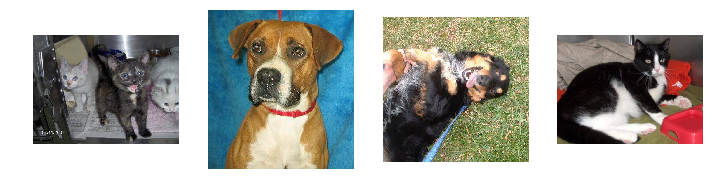

In [30]:
plots_array(test_path,test_batches.filenames[:4])